In [1]:
!pip install -q huggingface_hub

from huggingface_hub import notebook_login
notebook_login()

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model_name = "meta-llama/Llama-3.1-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype=torch.bfloat16,
    device_map="auto"
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

## Getting the data and data inspection

In [4]:
import json

with open("iclr2024.json", "r", encoding="utf-8") as f:
    data = [json.loads(line) for line in f]

In [5]:
import pandas as pd

df = pd.DataFrame(data)
df.head()


,venue,year,paper_id,title,abstract,decision,label,reviews
0,ICLR.cc,2024,cXs5md5wAq,Modelling Microbial Communities with Graph Neu...,Understanding the interactions and interplay o...,Reject,0,[{'summary': 'The paper aims at predicting ste...
1,ICLR.cc,2024,rhgIgTSSxW,TabR: Tabular Deep Learning Meets Nearest Neig...,Deep learning (DL) models for tabular data pro...,Accept (poster),1,[{'summary': 'This paper considers the problem...
2,ICLR.cc,2024,kKRbAY4CXv,Neural Evolutionary Kernel Method: A Knowledge...,Numerical solution of partial differential equ...,Reject,0,[{'summary': 'The paper introduces a novel app...
3,ICLR.cc,2024,ApjY32f3Xr,PINNacle: A Comprehensive Benchmark of Physics...,While significant progress has been made on Ph...,Reject,0,[{'summary': 'This paper provides both a colle...
4,ICLR.cc,2024,eUgS9Ig8JG,SaNN: Simple Yet Powerful Simplicial-aware Neu...,Simplicial neural networks (SNNs) are deep mod...,Accept (spotlight),1,[{'summary': 'The paper describes an efficient...


In [6]:
df.columns

Index(['venue', 'year', 'paper_id', 'title', 'abstract', 'decision', 'label',
       'reviews'],
      dtype='object')

Since reviews is a nested object, it will be easier to work with if we flatten it into text.

In [7]:
def flatten_reviews(reviews):
    if isinstance(reviews, list):
        return "\n\n".join([
            f"Reviewer {i+1}: {r.get('text','')}" for i, r in enumerate(reviews)
        ])
    return str(reviews)

df["reviews_text"] = df["reviews"].apply(flatten_reviews)

In [8]:
df[["reviews", "reviews_text"]].head()

,reviews,reviews_text
0,[{'summary': 'The paper aims at predicting ste...,Reviewer 1: \n\nReviewer 2: \n\nReviewer 3: \n...
1,[{'summary': 'This paper considers the problem...,Reviewer 1: \n\nReviewer 2: \n\nReviewer 3: \n...
2,[{'summary': 'The paper introduces a novel app...,Reviewer 1: \n\nReviewer 2: \n\nReviewer 3: \n...
3,[{'summary': 'This paper provides both a colle...,Reviewer 1: \n\nReviewer 2: \n\nReviewer 3: \n...
4,[{'summary': 'The paper describes an efficient...,Reviewer 1: \n\nReviewer 2: \n\nReviewer 3: \n...


Not required, but ensure a consistent label with 0 being REJECT and 1 being ACCEPT

In [8]:
import numpy as np

def map_binary_label(x):
    if x == 1:
        return "ACCEPT"
    if x == 0:
        return "REJECT"
    return np.nan  # just in case

df["gold_label"] = df["label"].apply(map_binary_label)

print(df["gold_label"].value_counts(dropna=False))

gold_label
REJECT    5143
ACCEPT    2261
Name: count, dtype: int64


In [9]:
def normalize_row(row):
    # Try using 'label' first if it's non-null
    lab = row.get("label", None)
    if pd.notna(lab):
        s = str(lab).strip().lower()
        if s in ["1", "accept", "accepted", "true", "yes"]:
            return "ACCEPT"
        if s in ["0", "reject", "rejected", "false", "no"]:
            return "REJECT"
    # Fall back to 'decision'
    dec = row.get("decision", "")
    dec = str(dec).strip().lower()
    if "accept" in dec:
        return "ACCEPT"
    if "reject" in dec:
        return "REJECT"
    # everything else (withdrawn, desk reject, etc.) → drop later
    return np.nan

df["gold_label"] = df.apply(normalize_row, axis=1)

print("\nGold label counts BEFORE dropping NaN:")
print(df["gold_label"].value_counts(dropna=False))


Gold label counts BEFORE dropping NaN:
gold_label
REJECT    5143
ACCEPT    2261
Name: count, dtype: int64


In [10]:
df = df[df["gold_label"].notna()]
print("\nRows after keeping only ACCEPT/REJECT:", len(df))
print(df["gold_label"].value_counts())


Rows after keeping only ACCEPT/REJECT: 7404
gold_label
REJECT    5143
ACCEPT    2261
Name: count, dtype: int64


In [11]:
accept_df = df[df["gold_label"] == "ACCEPT"]
reject_df = df[df["gold_label"] == "REJECT"]

print("Accept count:", len(accept_df))
print("Reject count:", len(reject_df))

n = min(len(accept_df), len(reject_df), 200)

eval_df = pd.concat([
    accept_df.sample(n, random_state=42),
    reject_df.sample(n, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Eval set size:", len(eval_df))
print(eval_df["gold_label"].value_counts())

Accept count: 2261
Reject count: 5143
Eval set size: 400
gold_label
REJECT    200
ACCEPT    200
Name: count, dtype: int64


# Prompt Templates

## No Reviews

In [12]:
ICLR_CRITERIA_BLOCK = """
Here are the criteria for ACCEPTANCE:

1. Novel or significant contribution to machine learning or representation learning.
2. Methodology appears technically sound.
3. Results, as described, meaningfully support the claims.
4. The topic is clearly within ICLR’s scope.
5. The abstract is clear and understandable.
6. The work has potential impact or interest to the ICLR community.

Here are the typical reasons for REJECTION:

1. Out of scope for ICLR.
2. Lacks meaningful novelty (purely incremental or trivial).
3. Suggests serious methodological or experimental weaknesses.
4. Provides clearly insufficient evidence to support the claims.
5. The abstract is extremely unclear or incoherent.
"""

def build_abstract_only_prompt(title, abstract):
    return f"""You are an experienced area chair for the International Conference on Learning Representations (ICLR).
You are screening submissions based ONLY on the title and abstract.

{ICLR_CRITERIA_BLOCK}

TASK:
Given the title and abstract below, decide whether this paper should be ACCEPTED or REJECTED for ICLR.

First, decide ONLY the final decision.
Then, indicate YES/NO for each criterion.
Then, briefly explain your reasoning in 2–3 bullet points.

Output EXACTLY in this format:

Final decision: <ACCEPT or REJECT>

Criteria:
- Novel and significant contribution: <YES/NO>
- Methodologically sound: <YES/NO>
- Results support claims: <YES/NO>
- Within ICLR scope: <YES/NO>
- Clear abstract: <YES/NO>
- Potential impact/interest: <YES/NO>

Rationale:
- <bullet 1>
- <bullet 2>
- <bullet 3>

Here is the submission:

Title: {title}

Abstract:
{abstract}
"""


## With Reviews

In [13]:
def build_with_reviews_prompt(title, abstract, reviews_text):
    return f"""You are an experienced area chair for the International Conference on Learning Representations (ICLR).
You are making a final recommendation using the title, abstract, and the reviewer reports.

{ICLR_CRITERIA_BLOCK}

Here are the REVIEWER REPORTS for this submission:
{reviews_text}

TASK:
Given the title, abstract, and reviews, decide whether this paper should be ACCEPTED or REJECTED for ICLR.

First, decide ONLY the final decision.
Then, indicate YES/NO for each criterion.
Then, briefly explain your reasoning in 2–3 bullet points, grounded in the reviews and abstract.

Output EXACTLY in this format:

Final decision: <ACCEPT or REJECT>

Criteria:
- Novel and significant contribution: <YES/NO>
- Methodologically sound: <YES/NO>
- Results support claims: <YES/NO>
- Within ICLR scope: <YES/NO>
- Clear abstract: <YES/NO>
- Potential impact/interest: <YES/NO>

Rationale:
- <bullet 1>
- <bullet 2>
- <bullet 3>

Here is the submission:

Title: {title}

Abstract:
{abstract}
"""


## Generate LLaMA function and helpers

In [14]:
def llama_generate(prompt, max_new_tokens=256):
    input_ids = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        output_ids = model.generate(
            **input_ids,
            max_new_tokens=max_new_tokens,
            do_sample=False,      # deterministic
            temperature=0.0
        )
    full_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    # Return only the model continuation (strip the prompt)
    return full_text[len(prompt):].strip()

In [15]:
import re

def parse_decision(llm_output):
    """
    Extract 'ACCEPT' or 'REJECT' from a line like:
    'Final decision: ACCEPT'
    """
    match = re.search(r"Final decision:\s*(ACCEPT|REJECT)", llm_output, re.IGNORECASE)
    if match:
        return match.group(1).upper()
    return None  # if parsing fails

Make predictions in both settings: Abstract only and abstract + review text

In [16]:
preds_abstract_only = []

for _, row in eval_df.iterrows():
    prompt = build_abstract_only_prompt(row["title"], row["abstract"])
    output = llama_generate(prompt)
    decision = parse_decision(output)
    if decision is None:
        decision = "REJECT"
    preds_abstract_only.append(decision)

eval_df["pred_abstract_only"] = preds_abstract_only


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for op

In [18]:
preds_with_reviews = []

for _, row in eval_df.iterrows():
    reviews_text = row["reviews"]
    prompt = build_with_reviews_prompt(row["title"], row["abstract"], reviews_text)
    output = llama_generate(prompt)
    decision = parse_decision(output)
    if decision is None:
        decision = "REJECT"
    preds_with_reviews.append(decision)

eval_df["pred_with_reviews"] = preds_with_reviews

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

## Evaluations

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def evaluate_predictions(y_true, y_pred, label="ACCEPT"):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=["ACCEPT", "REJECT"])
    # cm = [[TP, FN],
    #       [FP, TN]] when label order is ["ACCEPT", "REJECT"]
    TP, FN, FP, TN = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0.0  # recall for ACCEPT
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0  # recall for REJECT

    print("Accuracy:", acc)
    print("Sensitivity (ACCEPT recall):", sensitivity)
    print("Specificity (REJECT recall):", specificity)
    print("Confusion matrix (rows: true [ACCEPT, REJECT], cols: pred [ACCEPT, REJECT]):")
    print(cm)
    print("\nDetailed classification report:")
    print(classification_report(y_true, y_pred, labels=["ACCEPT", "REJECT"]))

# Abstract-only
evaluate_predictions(eval_df["gold_label"], eval_df["pred_abstract_only"])

# With reviews
evaluate_predictions(eval_df["gold_label"], eval_df["pred_with_reviews"])


Accuracy: 0.495
Sensitivity (ACCEPT recall): 0.98
Specificity (REJECT recall): 0.01
Confusion matrix (rows: true [ACCEPT, REJECT], cols: pred [ACCEPT, REJECT]):
[[196   4]
 [198   2]]

Detailed classification report:
              precision    recall  f1-score   support

      ACCEPT       0.50      0.98      0.66       200
      REJECT       0.33      0.01      0.02       200

    accuracy                           0.49       400
   macro avg       0.42      0.49      0.34       400
weighted avg       0.42      0.49      0.34       400

Accuracy: 0.535
Sensitivity (ACCEPT recall): 0.38
Specificity (REJECT recall): 0.69
Confusion matrix (rows: true [ACCEPT, REJECT], cols: pred [ACCEPT, REJECT]):
[[ 76 124]
 [ 62 138]]

Detailed classification report:
              precision    recall  f1-score   support

      ACCEPT       0.55      0.38      0.45       200
      REJECT       0.53      0.69      0.60       200

    accuracy                           0.54       400
   macro avg       0.

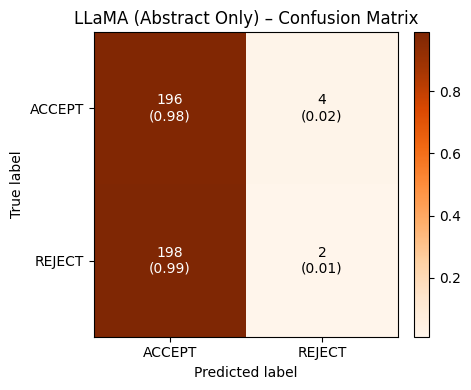

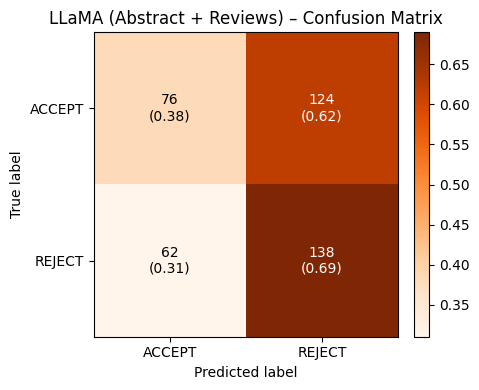

In [25]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["ACCEPT", "REJECT"]

def plot_confusion_matrix(y_true, y_pred, title, cmap="Blues"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)

    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm_norm, interpolation='nearest', cmap=cmap)

    ax.set_title(title)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    # Annotate with counts + normalized values
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm_norm[i, j]
            text_color = "white" if value > 0.5 else "black"
            text = f"{cm[i, j]}\n({value:.2f})"
            ax.text(j, i, text, ha="center", va="center", color=text_color, fontsize=10)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


# Abstract-only confusion matrix
plot_confusion_matrix(
    eval_df["gold_label"],
    eval_df["pred_abstract_only"],
    "LLaMA (Abstract Only) – Confusion Matrix",
    cmap="Oranges"   # <-- try Blues or Oranges
)

# With-reviews confusion matrix
plot_confusion_matrix(
    eval_df["gold_label"],
    eval_df["pred_with_reviews"],
    "LLaMA (Abstract + Reviews) – Confusion Matrix",
    cmap="Oranges"
)


In [22]:
def get_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=["ACCEPT", "REJECT"])
    TP, FN, FP, TN = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0
    return acc, sensitivity, specificity

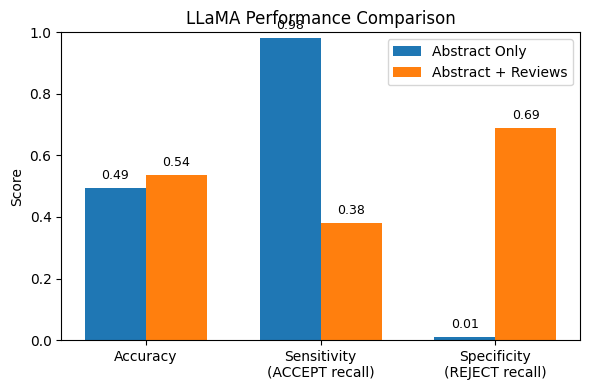

In [23]:
# Compute metrics for both setups
acc_abs, sen_abs, spec_abs = get_metrics(eval_df["gold_label"], eval_df["pred_abstract_only"])
acc_rev, sen_rev, spec_rev = get_metrics(eval_df["gold_label"], eval_df["pred_with_reviews"])

metrics = ["Accuracy", "Sensitivity\n(ACCEPT recall)", "Specificity\n(REJECT recall)"]
abstract_vals = [acc_abs, sen_abs, spec_abs]
review_vals   = [acc_rev, sen_rev, spec_rev]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(x - width/2, abstract_vals, width, label="Abstract Only")
ax.bar(x + width/2, review_vals,   width, label="Abstract + Reviews")

ax.set_ylabel("Score")
ax.set_ylim(0, 1.0)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_title("LLaMA Performance Comparison")
ax.legend()

for i, v in enumerate(abstract_vals):
    ax.text(x[i] - width/2, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=9)
for i, v in enumerate(review_vals):
    ax.text(x[i] + width/2, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


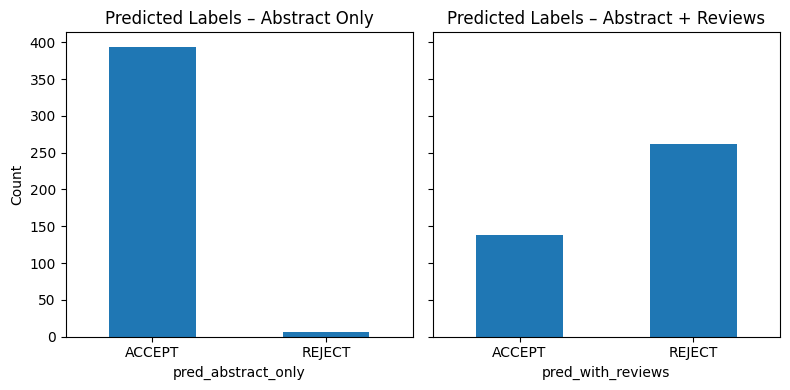

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(8,4), sharey=True)

eval_df["pred_abstract_only"].value_counts().reindex(labels).plot(
    kind="bar", ax=ax[0], rot=0
)
ax[0].set_title("Predicted Labels – Abstract Only")
ax[0].set_ylabel("Count")

eval_df["pred_with_reviews"].value_counts().reindex(labels).plot(
    kind="bar", ax=ax[1], rot=0
)
ax[1].set_title("Predicted Labels – Abstract + Reviews")

plt.tight_layout()
plt.show()
